# Data Analysis Report for BYTE
## First Place (1st/49 Teams) at BOLT UBC First Byte Datathon Sep 2023
#### Author: Chi Pham  
#### Team Members: Khoa Bui, Chi Pham, Finn Pham, Wendy Phung  
#### Summary: The analysis supports our recommendations on how to increase sales and profits for a retail company named B/YTE. The analysis uses a data set provided with the case.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import altair as alt
from altair import datum
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## READING & CLEANING

### Reading

In [2]:
df = pd.read_csv('dataset.csv', index_col=0)
og_df = pd.read_csv('dataset.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True, errors='coerce')
df.head(5)

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Operational_Cost,Customer_Age
0,2022-01-02,3686,3,Skirt,CZUZX,1.0,63.5,44.6,51
1,2022-01-02,3719,4,Skirt,549KK,1.0,55.9,41.1,27
2,2022-01-02,9200,5,Skirt,K8EHH,1.0,68.8,52.6,39
3,2022-01-02,1666,7,Shoes,AHZNS,1.0,82.1,56.7,39
4,2022-01-02,1253,8,Skirt,9STQJ,1.0,82.5,58.7,30


In [3]:
# Dimension
df.shape

(61863, 9)

In [4]:
# Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61863 entries, 0 to 61862
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              61708 non-null  datetime64[ns]
 1   Customer_ID       61863 non-null  int64         
 2   Transaction_ID    61863 non-null  int64         
 3   SKU_Category      61863 non-null  object        
 4   SKU               61863 non-null  object        
 5   Quantity          61863 non-null  float64       
 6   Sales_Amount      61863 non-null  float64       
 7   Operational_Cost  61863 non-null  float64       
 8   Customer_Age      61863 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 4.7+ MB


### Error Cleaning

Date is the only column with missing values. Speculation: Feb 29th, 2022 is not a valid date. Hence, when `errors='coerce'` is enforced, data points with this date will return NA

In [5]:
og_df[og_df['Date'] == '29/02/2022'].shape

(155, 9)

In [6]:
df['Date'].isnull().sum()

155

Speculation confirmed. Our first error is the 155 rows where the date is not real. We will get rid of these 155 rows

In [7]:
df = df[df['Date'].notnull()]

Filter out those with invalid quantity and change type to int

In [8]:
df[df['Quantity'] < 1].shape

(27, 9)

In [9]:
df = df[df['Quantity'] >= 1]

In [10]:
df['Quantity'] = df['Quantity'].fillna(0).astype(int)

Check for duplications in `Transaction_ID`

In [11]:
dup_test_df = df.groupby('Transaction_ID')['Customer_ID'].apply(set)
for i in dup_test_df:
    if len(i) > 1:
        print(i)

Ensure there are no NAs

In [12]:
df.isna().sum()

Date                0
Customer_ID         0
Transaction_ID      0
SKU_Category        0
SKU                 0
Quantity            0
Sales_Amount        0
Operational_Cost    0
Customer_Age        0
dtype: int64

## FEATURE ENGINEERING

In [13]:
df.head(5)

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Operational_Cost,Customer_Age
0,2022-01-02,3686,3,Skirt,CZUZX,1,63.5,44.6,51
1,2022-01-02,3719,4,Skirt,549KK,1,55.9,41.1,27
2,2022-01-02,9200,5,Skirt,K8EHH,1,68.8,52.6,39
3,2022-01-02,1666,7,Shoes,AHZNS,1,82.1,56.7,39
4,2022-01-02,1253,8,Skirt,9STQJ,1,82.5,58.7,30


Extract `day_of_week` from `Date` column. Values: Monday, Tuesday, etc.

In [14]:
df['day_of_week'] = df['Date'].dt.day_name()

Calculate `sales_per_piece` given `Sales_Amount` and `Quantity`

In [15]:
df['sales_per_piece'] = round(df['Sales_Amount'] / df['Quantity'] * 1.0, 1)

Cost/Sales `ratio` (percentage) from `Operational_Cost` and calculated `sales_per_piece`

In [16]:
df['ratio'] = df['Operational_Cost'] / df['sales_per_piece'] * 100

Calculate `profit` for each row, `profit` per 1 item

In [17]:
df['profit'] = df['Sales_Amount'] - df['Operational_Cost']*df['Quantity']

Total Operation cost `total_cost` by each row

In [18]:
df['total_cost'] = df['Quantity'] * df['Operational_Cost']

Create `age_group` from `Customer_Age`: 18-24, 25-34, 35-44, 45-54, 55-64, 65+

In [19]:
def age_group(row):
    if row['Customer_Age'] <= 24:
        group = '18-24'
    elif row['Customer_Age'] <= 34 and row['Customer_Age'] >= 25:
        group = '25-34'
    elif row['Customer_Age'] <= 44 and row['Customer_Age'] >= 35:
        group = '35-44'
    elif row['Customer_Age'] <= 54 and row['Customer_Age'] >= 45:
        group = '45-54'
    elif row['Customer_Age'] <= 64 and row['Customer_Age'] >= 55:
        group = '55-64'
    else:
        group = '65+'
    
    return group
df['age_group'] = df.apply(age_group, axis=1)
df.head(3)

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Operational_Cost,Customer_Age,day_of_week,sales_per_piece,ratio,profit,total_cost,age_group
0,2022-01-02,3686,3,Skirt,CZUZX,1,63.5,44.6,51,Sunday,63.5,70.236220,18.9,44.6,45-54
1,2022-01-02,3719,4,Skirt,549KK,1,55.9,41.1,27,Sunday,55.9,73.524150,14.8,41.1,25-34
2,2022-01-02,9200,5,Skirt,K8EHH,1,68.8,52.6,39,Sunday,68.8,76.453488,16.2,52.6,35-44


## EDA

In [20]:
df.sort_values('Quantity', ascending=False).head(10)

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Operational_Cost,Customer_Age,day_of_week,sales_per_piece,ratio,profit,total_cost,age_group
3036,2022-01-19,6442,2889,Cargo pants,OV1P9,20,1145.4,39.1,52,Wednesday,57.3,68.237347,363.4,782.0,45-54
2128,2022-01-14,6442,2011,Cargo pants,OV1P9,20,1145.6,39.1,52,Friday,57.3,68.237347,363.6,782.0,45-54
58473,2022-12-21,18013,62938,Blazer,0PW5H,12,949.1,47.0,54,Wednesday,79.1,59.418458,385.1,564.0,45-54
34865,2022-08-30,19404,41478,Shorts,2SVKS,10,220.9,16.7,29,Tuesday,22.1,75.565611,53.9,167.0,25-34
22286,2022-05-12,17471,23196,Hoodie,DUWYY,9,251.2,18.6,52,Thursday,27.9,66.666667,83.8,167.4,45-54
44671,2022-10-17,19192,50464,Shorts,2SVKS,9,198.9,16.7,19,Monday,22.1,75.565611,48.6,150.3,18-24
22900,2022-05-15,17471,23899,Hoodie,DUWYY,9,251.2,18.6,52,Sunday,27.9,66.666667,83.8,167.4,45-54
11120,2022-03-08,3509,11060,Dress shirt,W53F2,9,109.2,9.9,35,Tuesday,12.1,81.818182,20.1,89.1,35-44
10847,2022-03-07,5371,10807,Dress shirt,W53F2,9,109.2,9.9,33,Monday,12.1,81.818182,20.1,89.1,25-34
21027,2022-05-05,3509,21820,Dress shirt,W53F2,9,109.2,9.9,35,Thursday,12.1,81.818182,20.1,89.1,35-44


In [21]:
df.shape

(61681, 15)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61681 entries, 0 to 61862
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              61681 non-null  datetime64[ns]
 1   Customer_ID       61681 non-null  int64         
 2   Transaction_ID    61681 non-null  int64         
 3   SKU_Category      61681 non-null  object        
 4   SKU               61681 non-null  object        
 5   Quantity          61681 non-null  int64         
 6   Sales_Amount      61681 non-null  float64       
 7   Operational_Cost  61681 non-null  float64       
 8   Customer_Age      61681 non-null  int64         
 9   day_of_week       61681 non-null  object        
 10  sales_per_piece   61681 non-null  float64       
 11  ratio             61681 non-null  float64       
 12  profit            61681 non-null  float64       
 13  total_cost        61681 non-null  float64       
 14  age_group         61681 non

Quantitative Summary

In [23]:
df.agg(
    {
        "Date": ['min', 'max', 'mean', 'median', 'std'],
        "Quantity": ['min', 'max', 'mean', 'median', 'std'],
        "Sales_Amount": ['min', 'max', 'mean', 'median', 'std'],
        "Operational_Cost": ['min', 'max', 'mean', 'median', 'std'],
        "Customer_Age": ['min', 'max', 'mean', 'median', 'std'],
        "sales_per_piece": ['min', 'max', 'mean', 'median', 'std'],
        "ratio": ['min', 'max', 'mean', 'median', 'std'],
    }
)

,Date,Quantity,Sales_Amount,Operational_Cost,Customer_Age,sales_per_piece,ratio
min,2022-01-02 00:00:00,1.000000,0.200000,0.100000,16.000000,0.200000,50.000000
max,2022-12-31 00:00:00,20.000000,2118.300000,1536.100000,68.000000,1942.000000,100.000000
mean,2022-07-05 22:58:48.619834112,1.315754,88.968023,52.002276,41.160957,72.786343,71.287655
median,2022-07-04 00:00:00,1.000000,63.500000,38.700000,41.000000,56.600000,70.061728
std,107 days 16:45:46.219037476,0.659417,104.067195,67.125790,11.238115,87.208718,7.435218


**Summary**: 
1. Only 1 year data - 2022  
2. Mean age around 41  
3. Average cost/sales ratio is around 71.2%  
4. Mostly 1 item per transaction

In [24]:
df.sort_values(by='sales_per_piece', ascending=False).head(3)

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Operational_Cost,Customer_Age,day_of_week,sales_per_piece,ratio,profit,total_cost,age_group
58860,2022-12-22,17045,63313,Sunglasses,4Y96V,1,1942.0,1536.1,59,Thursday,1942.0,79.098867,405.9,1536.1,55-64
50246,2022-11-15,15800,55620,Sunglasses,4Y96V,1,1942.0,1536.1,40,Tuesday,1942.0,79.098867,405.9,1536.1,35-44
28991,2022-06-20,17045,30658,Sunglasses,4Y96V,1,1942.0,1536.1,59,Monday,1942.0,79.098867,405.9,1536.1,55-64


In [25]:
df['SKU_Category'].unique()

array(['Skirt', 'Shoes', 'T-shirt', 'Cargo pants', 'Crop Top', 'Jeans',
       'Hoodie', 'Sunglasses', 'Blazer', 'Dress shirt', 'Bomber jacket',
       'Trench coat', 'Dresses', 'Hat', 'Shorts'], dtype=object)

In [26]:
pd.crosstab(df['SKU_Category'], columns='Count').sort_values(by='Count', ascending=False)

col_0,Count
SKU_Category,
T-shirt,10894
Hoodie,5090
Dresses,5035
Cargo pants,4813
Shorts,4557
Skirt,4486
Hat,4296
Shoes,3154
Blazer,3027


Check whether each `SKU` code correspond to only one `SKU_Category` value

In [27]:
for i in df['SKU'].unique():
    if len(df[df['SKU'] == i]['SKU_Category'].unique()) > 1:
        print(df[df['SKU'] == i]['SKU_Category'].unique())

## PROBLEM IDENTIFICATION

### Problem 1: Too many `SKU` - Too many product lines per clothing Category.  
#### Assumption: We can reduce the number of product lines to cut cost while still retaining sales

Calculated 1432 products over 15 categories of clothing, averaging around 95 items/category.   
For a retail store that has only been operating for a year, this is too much.   
Additionally, this number of product lines is not on par with the company's mission - sustainability.

In [28]:
print(len(df['SKU'].unique()))
print(len(df['SKU'].unique()) / len(df['SKU_Category'].unique()))

1432
95.46666666666667


In [29]:
# Calculate current number of products per category
df.groupby('SKU_Category')['SKU'].nunique()

SKU_Category
Blazer            54
Bomber jacket    108
Cargo pants       82
Crop Top         123
Dress shirt       37
Dresses          265
Hat               79
Hoodie           114
Jeans             67
Shoes             86
Shorts            92
Skirt             89
Sunglasses        90
T-shirt           63
Trench coat       83
Name: SKU, dtype: int64

In [73]:
# Calculate top 3 best-selling lines of product (SKU) per category
for i in df['SKU_Category'].unique():
    print(i)
    print(pd.crosstab(df[df['SKU_Category']==i]['SKU'], columns='count').sort_values(by='count', ascending=False).head(3))

Skirt
col_0  count
SKU         
CZUZX    618
51OBI    411
9STQJ    301
Shoes
col_0  count
SKU         
F79YP    376
JJ9FT    291
83SE2    165
T-shirt
col_0  count
SKU         
UNJKW   2006
COWU2    789
M6J9W    698
Cargo pants
col_0  count
SKU         
OV1P9    734
DMJ70    519
JCYBN    398
Crop Top
col_0  count
SKU         
MRE4J    400
G5878    143
VXH0U    126
Jeans
col_0  count
SKU         
E3PAN    508
XJLWY    178
BK9BM    174
Hoodie
col_0  count
SKU         
F90L2    389
4R4F9    339
DLFQW    276
Sunglasses
col_0  count
SKU         
2IA22    232
7LJOW    191
0OZBT    162
Blazer
col_0  count
SKU         
A59HR    556
LPLTZ    482
PO1N6    298
Dress shirt
col_0  count
SKU         
SJ0ZD    446
6TXTJ    349
W53F2    312
Bomber jacket
col_0  count
SKU         
20XCP    342
YRULF    208
X59YE    181
Trench coat
col_0  count
SKU         
A9P11    321
93JH4    156
PFUQ1    141
Dresses
col_0  count
SKU         
CYAX0    279
5S43J    206
W85U8    196
Hat
col_0  count
SKU         
4FT32  

Based on market analysis and our own prediction, we only want to keep a number of top products that accounts for 80% of the company's current profit. There are 2 ways to go about this:  
1. For each category, we keep the number of top products that is accountable for 80% of the profit generated by that category  
2. Keep a number of top product lines that accounts for 80% of the company's profit as a whole  

We chose approach 1 since we believe this would align with the company's diversity value. However, both approach are presented below.

In [31]:
# Approach 1
df.groupby('SKU_Category')['profit'].sum()
result = {}
ratio_avg = {}
for i in df['SKU_Category'].unique():
    x = df[df['SKU_Category'] == i]
    top = x[['SKU', 'profit', 'Sales_Amount', 'Quantity']].groupby('SKU').agg('sum').sort_values(by='profit', ascending=False)
    totalPro = x['profit'].sum()
    totalSales = x['Sales_Amount'].sum()
    totalQuantity = x['Quantity'].sum()
    current_profit = 0
    current_sales = 0
    result[i] = []

    for index, row in top.iterrows():
        if current_profit/totalPro < 0.80:
            current_profit += row['profit']
            # current_sales += row['Sales_Amount']
            result[i].append(index)
        else:
            break
    

topProductsDict = {}
sku_keep = []
for key, value in result.items():
    topProductsDict[key] = len(value)
    sku_keep += value

topTable = pd.DataFrame(topProductsDict.items(), columns = ['category', 'num_top_products'])
topTable

,category,num_top_products
0,Skirt,24
1,Shoes,22
2,T-shirt,19
3,Cargo pants,25
4,Crop Top,38
5,Jeans,23
6,Hoodie,30
7,Sunglasses,23
8,Blazer,10
9,Dress shirt,13


In [60]:
# Approach 2
another_sku = []
new_df = df[['SKU', 'profit', 'Sales_Amount', 'Quantity']].groupby('SKU').agg('sum').sort_values(by='profit', ascending=False)
newTotalPro = df['profit'].sum()
curr = 0
for index, row in new_df.iterrows():
    if curr/newTotalPro < 0.80:
        curr += row['profit']
        another_sku.append(index)
    else:
        break

In [61]:
# Final result based on approach 1
topTable = topTable.sort_values(by='category').reset_index().drop('index', axis=1)
topTable['original_num'] = topTable['category'].map(df.groupby('SKU_Category')['SKU'].nunique().to_dict())
topTable['pct'] = round(topTable['num_top_products'] / topTable['original_num'] * 100)
topTable

,category,num_top_products,original_num,pct,avg_ratio,profit_ratio
0,Blazer,10,54,19.0,66.017298,5.083886
1,Bomber jacket,29,108,27.0,65.694999,7.761508
2,Cargo pants,25,82,30.0,68.691001,6.398309
3,Crop Top,38,123,31.0,81.360519,3.969418
4,Dress shirt,13,37,35.0,81.846497,3.183876
5,Dresses,87,265,33.0,71.830437,15.174925
6,Hat,25,79,32.0,80.560577,4.640733
7,Hoodie,30,114,26.0,67.235675,7.398923
8,Jeans,23,67,34.0,63.101822,5.283106
9,Shoes,22,86,26.0,66.254090,7.209700


In [35]:
# Filtered dataset based on approach 1
filtered = df[df['SKU'].isin(sku_keep)]
filtered.shape

(47240, 15)

In [62]:
# Filtered dataset based on approach 2
filtered_2 = df[df['SKU'].isin(another_sku)]
filtered_2.shape

(47198, 15)

In [95]:
print('Approach 1\n', filtered.groupby('SKU_Category')['SKU'].nunique())
print('Approach 2\n', filtered_2.groupby('SKU_Category')['SKU'].nunique())

Approach 1
 SKU_Category
Blazer           10
Bomber jacket    29
Cargo pants      25
Crop Top         38
Dress shirt      13
Dresses          87
Hat              25
Hoodie           30
Jeans            23
Shoes            22
Shorts           25
Skirt            24
Sunglasses       23
T-shirt          19
Trench coat      17
Name: SKU, dtype: int64
Approach 2
 SKU_Category
Blazer           13
Bomber jacket    32
Cargo pants      23
Crop Top         18
Dress shirt      13
Dresses          70
Hat              20
Hoodie           32
Jeans            23
Shoes            30
Shorts           15
Skirt            20
Sunglasses       21
T-shirt          28
Trench coat      20
Name: SKU, dtype: int64


Conclusion: Not much difference between the two approaches. We will go with approach 1

In [68]:
print(filtered['profit'].sum(), df['profit'].sum(), filtered['profit'].sum()/df['profit'].sum()*100)

1238330.3 1537040.7999999996 80.56587047006172


In [69]:
# For each category, calculate the mean cost/sales ratio 
ratio_dict = filtered[['SKU_Category', 'ratio']].groupby('SKU_Category').mean().to_dict()['ratio']
profit_total_dict = filtered[['SKU_Category', 'profit']].groupby('SKU_Category').sum().to_dict()['profit']
profit_ratio_dict = {}
for key, value in profit_total_dict.items():
    profit_ratio_dict[key] = value / filtered['profit'].sum() * 100
topTable['avg_ratio'] = topTable['category'].map(ratio_dict)
topTable['profit_ratio'] = topTable['category'].map(profit_ratio_dict)
topTable.sort_values('profit_ratio', ascending=False)

,category,num_top_products,original_num,pct,avg_ratio,profit_ratio
5,Dresses,87,265,33.0,71.830437,15.174925
13,T-shirt,19,63,30.0,67.585724,10.533991
1,Bomber jacket,29,108,27.0,65.694999,7.761508
14,Trench coat,17,83,20.0,57.782079,7.709219
7,Hoodie,30,114,26.0,67.235675,7.398923
9,Shoes,22,86,26.0,66.254090,7.209700
12,Sunglasses,23,90,26.0,80.960548,6.852816
2,Cargo pants,25,82,30.0,68.691001,6.398309
8,Jeans,23,67,34.0,63.101822,5.283106
11,Skirt,24,89,27.0,72.682196,5.264258


**28.6% of current products is accountable for 80% profit**

In [70]:
topTable['num_top_products'].sum() / len(df['SKU'].unique()) * 100

28.631284916201118

In [96]:
# More detail breakdown on the number of products kept and their contribution to profit, sales, and quantity sold
for i in df['SKU_Category'].unique():
    x = df[df['SKU_Category'] == i]
    top_only = x[['SKU', 'profit', 'Sales_Amount', 'Quantity']].groupby('SKU').agg('sum').sort_values(by='profit', ascending=False).head(topProductsDict[i])
    totalPro = x['profit'].sum()
    totalSales = x['Sales_Amount'].sum()
    totalQuantity = x['Quantity'].sum()
    print('\n'+i)
    print('Profit pct: ', top_only['profit'].sum()/totalPro*100)
    print('Sales pct: ', top_only['Sales_Amount'].sum()/totalSales*100)
    print('Quantity pct: ', top_only['Quantity'].sum()/totalQuantity*100)


Skirt
Profit pct:  80.94782198380767
Sales pct:  80.02392284262187
Quantity pct:  78.14054054054054

Shoes
Profit pct:  80.90061844460048
Sales pct:  81.4844728009342
Quantity pct:  79.67016491754123

T-shirt
Profit pct:  81.18599657694102
Sales pct:  81.0843580143958
Quantity pct:  74.69074715487383

Cargo pants
Profit pct:  80.32746498507146
Sales pct:  80.08658212523986
Quantity pct:  81.80242634315424

Crop Top
Profit pct:  80.18364696977606
Sales pct:  80.29183691897872
Quantity pct:  82.09802749551703

Jeans
Profit pct:  80.72820649504814
Sales pct:  81.01474042055436
Quantity pct:  80.72289156626506

Hoodie
Profit pct:  80.10727821954876
Sales pct:  79.33948831542554
Quantity pct:  78.87047924461072

Sunglasses
Profit pct:  80.27396664194579
Sales pct:  80.08179118991303
Quantity pct:  55.89981926155435

Blazer
Profit pct:  81.83090829210721
Sales pct:  82.61946570236198
Quantity pct:  81.7340734866508

Dress shirt
Profit pct:  80.24998931408649
Sales pct:  79.62877853738836
Qu

### Problem 2: Sole supplier from Germany - given in case package
#### Recommendation: We can source products from multiple suppliers to cater demand and reduce service disruption. Need to determine which products to order locally - products that are in `high demand` and `low cost/sales ratio`.

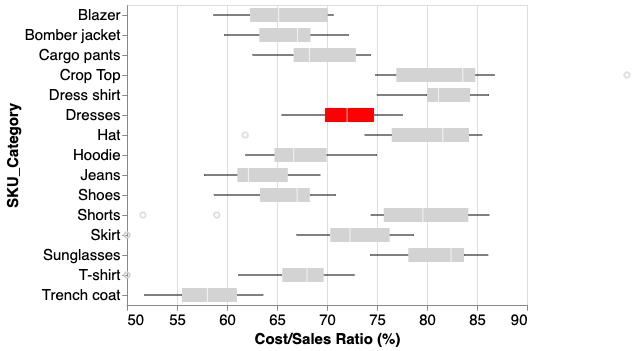

In [81]:
# Cost/Sales Ratio Chart
interact = alt.Chart(df).mark_boxplot().encode(
    alt.Y('SKU_Category'),
    alt.X('ratio', title='Cost/Sales Ratio (%)', scale=alt.Scale(domain=[50, 90])),
    alt.Tooltip('mean(ratio)'),
    color=alt.condition(
        alt.datum.SKU_Category == 'Dresses',  # If the country is "US" this test returns True,
        alt.value('red'),     # highlight a bar with red.
        alt.value('lightgrey')   # And grey for the rest of the bars
     )
).configure_mark(
    color='#5f84a2',
).configure_axis(
    labelFontSize=15,
    titleFontSize=15
)
interact

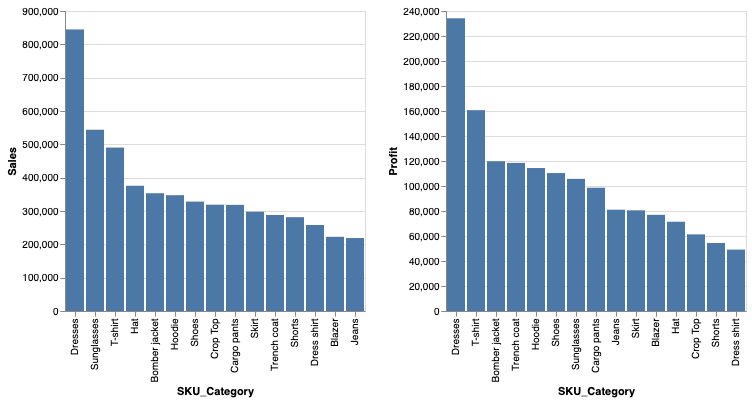

In [79]:
# Sales and Profit chart
sales = alt.Chart(df).mark_bar().encode(
    alt.X('SKU_Category', sort='-y'),
    alt.Y('sum(Sales_Amount)', title='Sales'),
)

profit = alt.Chart(df).mark_bar().encode(
    alt.X('SKU_Category', sort='-y'),
    alt.Y('sum(profit)', title='Profit'),
)

sales | profit

Should order products such as `Dresses`, `T-shirt`, or `Bomber Jacket` locally

## ADDITIONAL VISUAL SUMMARIZATION

In [82]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('data_server')

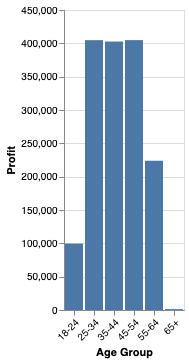

In [84]:
# Summary of Age Distribution
alt.Chart(df).mark_bar().encode(
    alt.X('age_group:N', title='Age Group', axis=alt.Axis(labelAngle=-45)),
    alt.Y('sum(profit)', title='Profit')
)

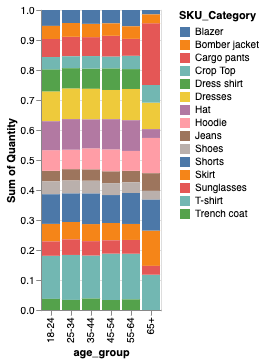

In [85]:
# Comparision of favored category within age groups
alt.Chart(df).mark_bar().encode(
    alt.X('age_group'),
    alt.Y('sum(Quantity)', stack='normalize'),
    alt.Color('SKU_Category')
)

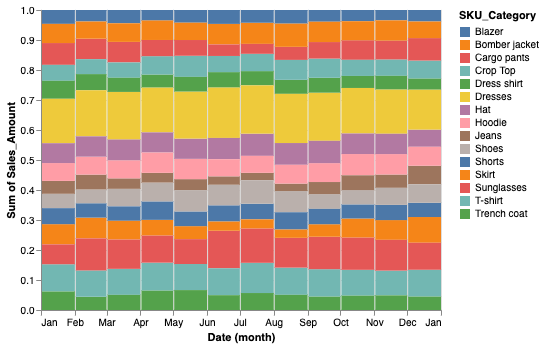

In [86]:
# Identification of yearly trends: None
alt.Chart(df).mark_bar().encode(
    alt.X('month(Date)'),
    alt.Y('sum(Sales_Amount)', stack='normalize'),
    alt.Color('SKU_Category')
)

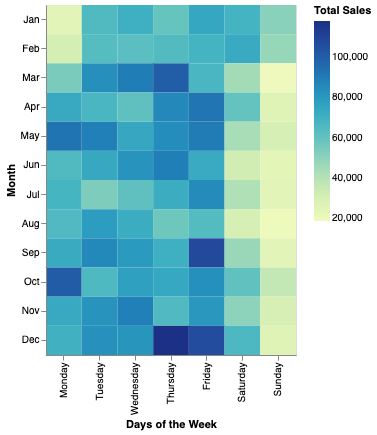

In [88]:
# Weekly trends - Low sales on weekends
daysInWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
alt.Chart(df).mark_rect().encode(
    alt.Y('month(Date):O', title='Month'),
    alt.X('day_of_week:O', sort=daysInWeek, title='Days of the Week'),
    alt.Color('sum(Sales_Amount)', title='Total Sales'),
    alt.Tooltip('sum(Sales_Amount)')
).properties(
    width=250,
    height=350
)

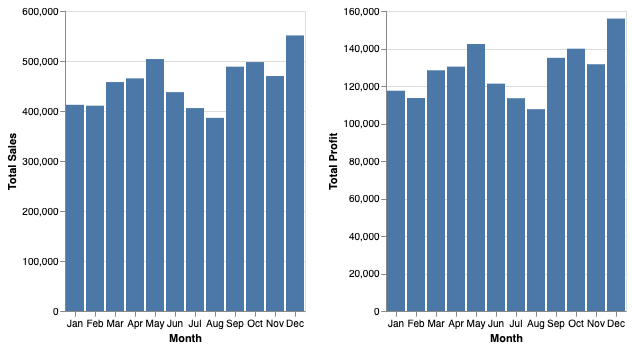

In [91]:
# Identify Seasonality
profit_year = alt.Chart(df).mark_bar().encode(
    alt.Y('sum(profit)', title='Total Profit'),
    alt.X('month(Date):O', title='Month')
)

sales_year = alt.Chart(df).mark_bar().encode(
    alt.Y('sum(Sales_Amount)', title='Total Sales'),
    alt.X('month(Date):O', title='Month')
)

sales_year | profit_year

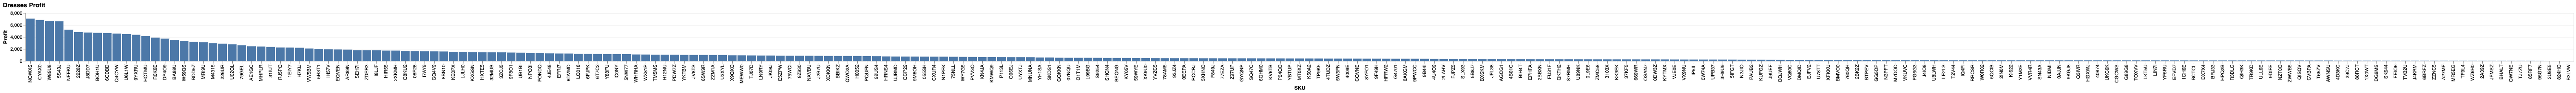

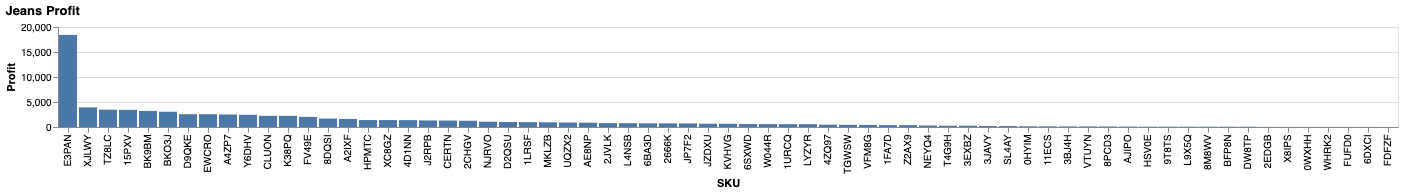

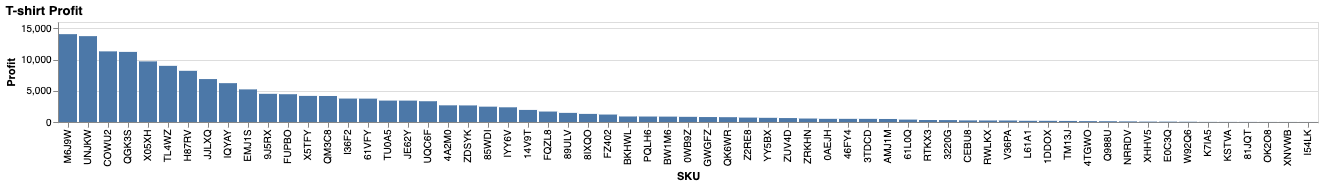

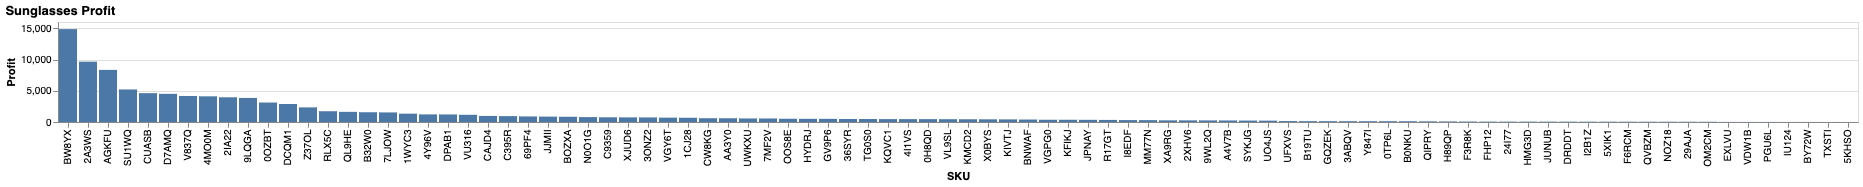

In [93]:
# Function for ploting Sales/Profit of all lines of products across all categories
def plotBarSales(i):
    x = df[df['SKU_Category'] == i]
    plot = alt.Chart(x).mark_bar().encode(
        alt.X('SKU', sort='-y'),
        alt.Y('sum(Sales_Amount)')
    ).properties(
        title=i+'Sales'
    ).configure_title(
     anchor='start'
    )
    return plot.display()

def plotBarProfit(i):
    x = df[df['SKU_Category'] == i]
    plot = alt.Chart(x).mark_bar().encode(
        alt.X('SKU', sort='-y'),
        alt.Y('sum(profit)', title='Profit')
    ).properties(
        title=i+' Profit'
    ).configure_title(
    anchor='start'
    ).properties(
        height=100,
    )
    return plot.display()

for i in ['Dresses', 'Jeans', 'T-shirt', 'Sunglasses']:
    plotBarProfit(i)